<a href="https://colab.research.google.com/github/NohemiVargas/Procesamiento_y_clasificacion_datos/blob/main/Tarea1/Maternity_risk_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Avance Tarea 1. Maternity Risk identification
Laura Nohemí Vargas de la Rosa

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip3 install fitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fitter: filename=fitter-1.5.2-py3-none-any.whl size=25609 sha256=51b1d52572febbb5a505289b963feb3df22bf653db0a3ddd2b534a0166f424c5
  Stored in directory: /root/.cache/pip/wheels/8e/6b/cb/628035771acab95dc84f200590b4838c7c3095a70ede67a25a
Successfully built fitter


### Importing Libraries

In [31]:
# Data treatment
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

# Graphs
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Pre processing and modeling
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
# Others
# ==============================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions




### Exploratory Analysis

#### Read the file

In [7]:
data=pd.read_csv('/content/drive/MyDrive/Colaboratory/Procesamiento y clasificación de Datos/Tarea 1/Maternal Health Risk Data Set.csv')

#### First 4 values

In [8]:
data.head(4)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk


#### Column type

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


#### Number of observations and null values

#####Dataset dimensions



In [12]:
data.shape

(1014, 7)

#####Null observations per variable

In [13]:
data.isna().sum().sort_values()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

#### Numerical variables

#####Descriptive statistics for numerical variables

In [15]:
data.select_dtypes(include=['float64', 'int']).describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


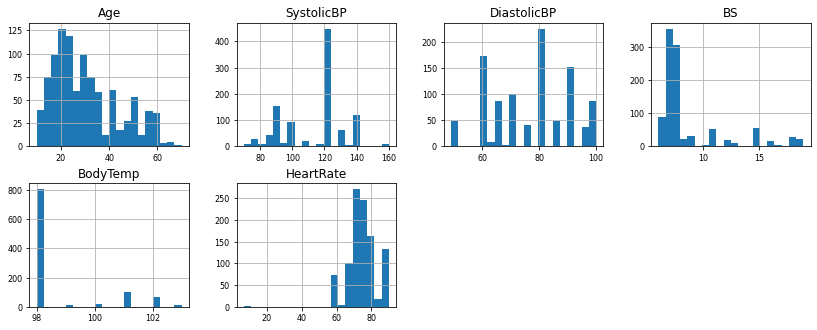

In [16]:
numerical=data.select_dtypes(include=[np.number]).columns.tolist()
data[numerical].hist(bins=20, figsize=(14, 20), layout=(7, 4), xlabelsize=8, ylabelsize=8);

#####Correlation


In [17]:
def tidy_corr_matrix(corr_mat):
    '''
    Function to convert a pandas correlation matrix in tidy format
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

data2 = data.drop('RiskLevel', axis=1)

corr_matrix =  data2.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)


,variable_1,variable_2,r,abs_r
13,DiastolicBP,SystolicBP,0.787006,0.787006
8,SystolicBP,DiastolicBP,0.787006,0.787006
18,BS,Age,0.473284,0.473284
3,Age,BS,0.473284,0.473284
19,BS,SystolicBP,0.425172,0.425172
9,SystolicBP,BS,0.425172,0.425172
20,BS,DiastolicBP,0.423824,0.423824
15,DiastolicBP,BS,0.423824,0.423824
1,Age,SystolicBP,0.416045,0.416045
6,SystolicBP,Age,0.416045,0.416045


#####Correlation heatmap

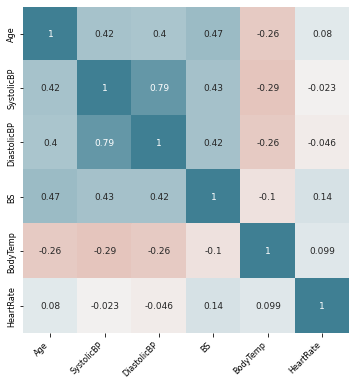

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 9},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)


#### Dependent (Response) variable: RiskLevel (Cualitative)

#####Risk Level frequency

In [22]:
pd.value_counts(data['RiskLevel'])

low risk     406
mid risk     336
high risk    272
Name: RiskLevel, dtype: int64

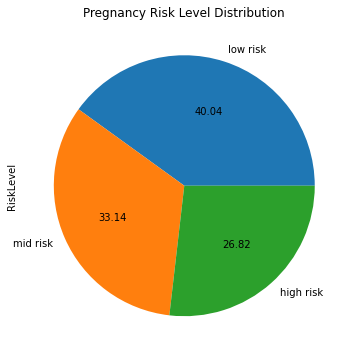

In [23]:
plot = data['RiskLevel'].value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(6, 6),
                                            title='Pregnancy Risk Level Distribution')

#####Variable distribution per Risk Level

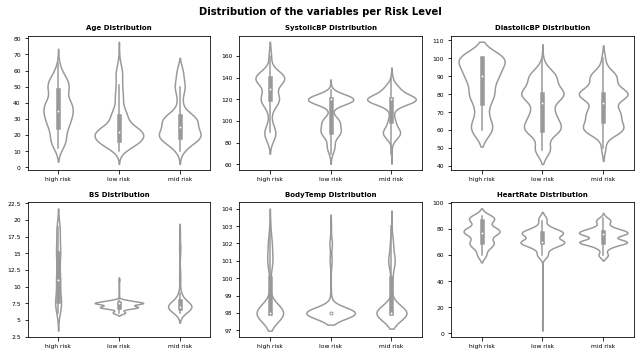

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = data.select_dtypes(include=['float64', 'int']).columns
for i, colum in enumerate(columnas_numeric):
    sns.violinplot(
        x     = 'RiskLevel',
        y     = colum,
        data  = data,
        color = "white",
        ax    = axes[i]
    )
    axes[i].set_title(f"{colum} Distribution", fontsize = 7, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribution of the variables per Risk Level', fontsize = 10, fontweight = "bold");

#####Standardization

In [35]:
  sc=StandardScaler()
#sc=MinMaxScaler()
data_standard=sc.fit_transform(data2)
data_standard=pd.DataFrame(data_standard)
data_standard.columns=['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
data_standard.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,-0.361738,0.913396,0.255023,1.905890,-0.485215,1.446956
1,0.380777,1.457027,0.975539,1.298340,-0.485215,-0.532088
2,-0.064732,-1.261127,-0.465493,-0.220537,0.973884,0.704815
3,0.009519,1.457027,0.615281,-0.524312,-0.485215,-0.532088
4,0.380777,0.369765,-1.186009,-0.797710,-0.485215,0.210054


In [36]:
data_standard.select_dtypes(include=['float64', 'int']).describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1.014000e+03,1.014000e+03,1.014000e+03,1.014000e+03,1.014000e+03,1.014000e+03
mean,-4.905127e-17,-7.708057e-17,4.694908e-16,-2.137234e-16,2.151249e-15,1.366428e-16
std,1.000493e+00,1.000493e+00,1.000493e+00,1.000493e+00,1.000493e+00,1.000493e+00
min,-1.475511e+00,-2.348389e+00,-1.978576e+00,-8.280872e-01,-4.852155e-01,-8.324572e+00
25%,-8.072472e-01,-7.174962e-01,-8.257508e-01,-5.546894e-01,-4.852155e-01,-5.320876e-01
50%,-2.874866e-01,3.697655e-01,2.550228e-01,-3.724243e-01,-4.852155e-01,2.100538e-01
75%,6.777830e-01,3.697655e-01,9.755385e-01,-2.205366e-01,-4.852155e-01,7.048148e-01
max,2.979580e+00,2.544289e+00,1.696054e+00,3.120991e+00,3.162534e+00,1.941717e+00


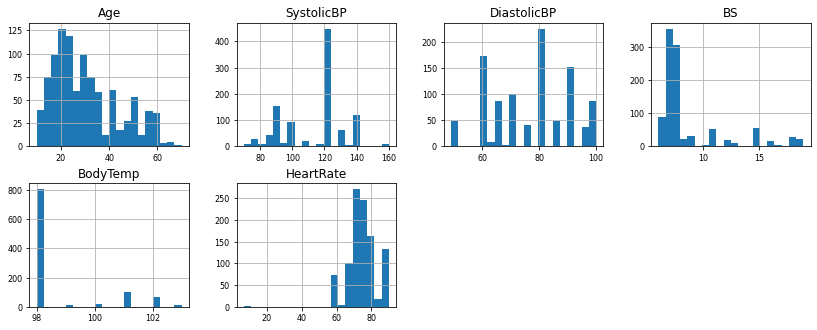

In [37]:
numerical_std=data_standard.select_dtypes(include=[np.number]).columns.tolist()
data[numerical_std].hist(bins=20, figsize=(14, 20), layout=(7, 4), xlabelsize=8, ylabelsize=8);

In [38]:
minmax=MinMaxScaler()
#sc=MinMaxScaler()
data_minmax=minmax.fit_transform(data2)
data_minmax=pd.DataFrame(data_minmax)
data_minmax.columns=['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
data_minmax.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,0.250000,0.666667,0.607843,0.692308,0.0,0.951807
1,0.416667,0.777778,0.803922,0.538462,0.0,0.759036
2,0.316667,0.222222,0.411765,0.153846,0.4,0.879518
3,0.333333,0.777778,0.705882,0.076923,0.0,0.759036
4,0.416667,0.555556,0.215686,0.007692,0.0,0.831325


In [39]:
data_minmax.select_dtypes(include=['float64', 'int']).describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,0.331197,0.479980,0.538442,0.209691,0.133018,0.810865
std,0.224573,0.204488,0.272271,0.253349,0.274277,0.097454
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150000,0.333333,0.313725,0.069231,0.000000,0.759036
50%,0.266667,0.555556,0.607843,0.115385,0.000000,0.831325
75%,0.483333,0.555556,0.803922,0.153846,0.000000,0.879518
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


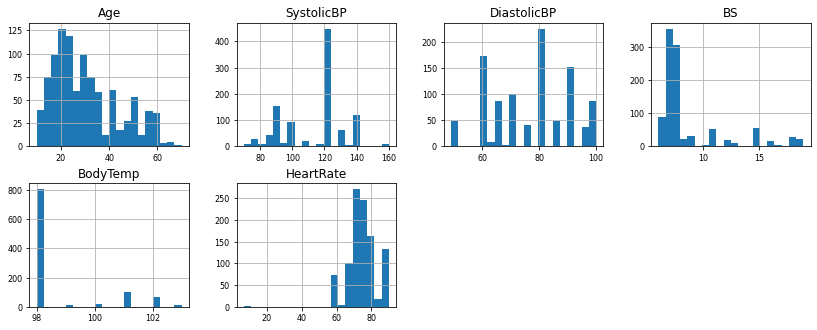

In [41]:
numerical_minmax=data_minmax.select_dtypes(include=[np.number]).columns.tolist()
data[numerical_minmax].hist(bins=20, figsize=(14, 20), layout=(7, 4), xlabelsize=8, ylabelsize=8);

#### K-means exploration

In [45]:
distortions = []
K = [2,3,4,5,6,7,8,9,10]
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=20, max_iter=50)
    kmeanModel.fit(data_standard)
    distortions.append(kmeanModel.inertia_)

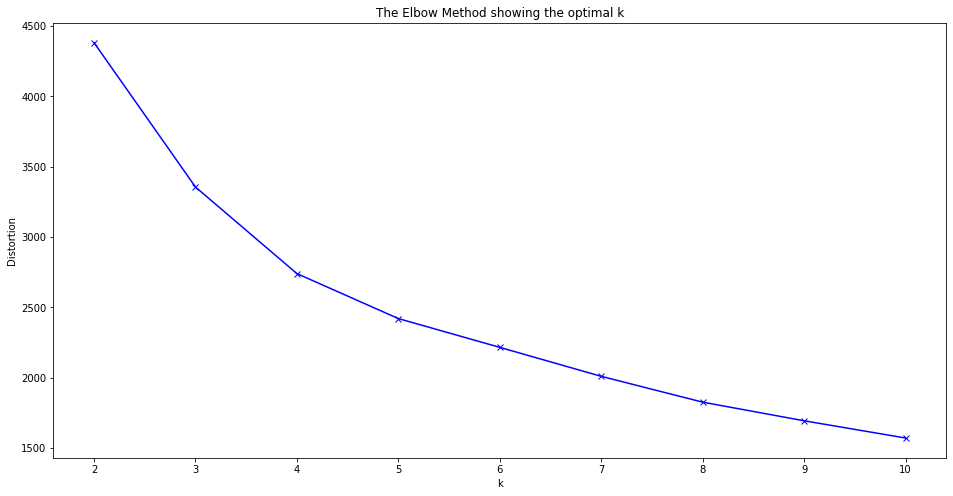

In [46]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [47]:
K = [2,3,4,5,6,7,8,9,10]
for k in K:
    kmeanModel = KMeans(n_clusters=k,n_init=20, max_iter=50)
    kmeanModel.fit(data_standard)
    cluster_labels = kmeanModel.labels_
    silhouette_avg=silhouette_score(data_standard, cluster_labels)
    print("For cluster={0}, the silhouette score is {1}".format(k,silhouette_avg))

For cluster=2, the silhouette score is 0.29712406651443757
For cluster=3, the silhouette score is 0.2926921227241734
For cluster=4, the silhouette score is 0.30618283951985487
For cluster=5, the silhouette score is 0.3037952564997844
For cluster=6, the silhouette score is 0.30662359775710957
For cluster=7, the silhouette score is 0.32029552723018284
For cluster=8, the silhouette score is 0.32219646706814353
For cluster=9, the silhouette score is 0.33123879001831563
For cluster=10, the silhouette score is 0.3339113207031304


In [48]:
distortions = []
K = [2,3,4,5,6,7,8,9,10]
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=20, max_iter=50)
    kmeanModel.fit(data_minmax)
    distortions.append(kmeanModel.inertia_)

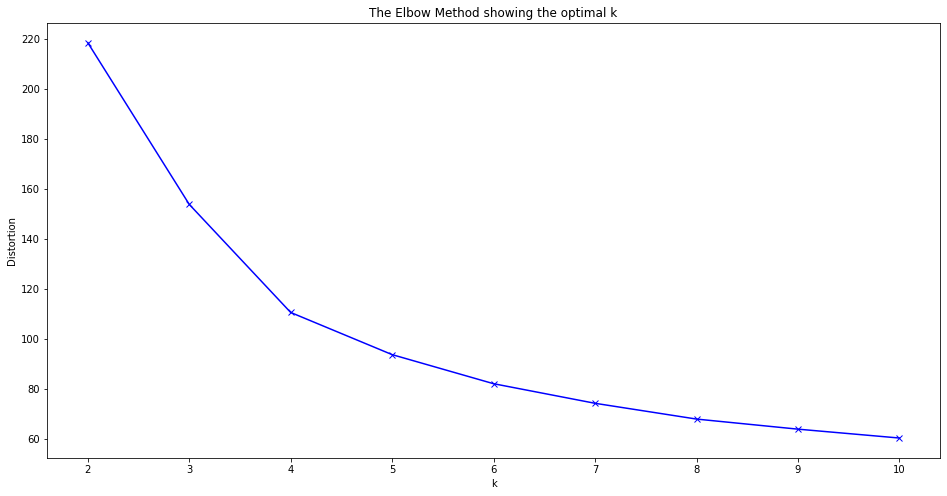

In [49]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [50]:
K = [2,3,4,5,6,7,8,9,10]
for k in K:
    kmeanModel = KMeans(n_clusters=k,n_init=20, max_iter=50)
    kmeanModel.fit(data_minmax)
    cluster_labels = kmeanModel.labels_
    silhouette_avg=silhouette_score(data_minmax, cluster_labels)
    print("For cluster={0}, the silhouette score is {1}".format(k,silhouette_avg))

For cluster=2, the silhouette score is 0.30558596140293004
For cluster=3, the silhouette score is 0.3853224114761459
For cluster=4, the silhouette score is 0.3756649780813517
For cluster=5, the silhouette score is 0.3752202365511822
For cluster=6, the silhouette score is 0.3847977517774291
For cluster=7, the silhouette score is 0.3496106515222612
For cluster=8, the silhouette score is 0.338880518508138
For cluster=9, the silhouette score is 0.345482295631977
For cluster=10, the silhouette score is 0.35722554703325404


In [51]:
kmeanModel = KMeans(n_clusters=3, max_iter=50)
kmeanModel.fit(data_minmax)

KMeans(max_iter=50, n_clusters=3)

In [52]:
data3=data;
data3['cluster']=kmeanModel.labels_
data3.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,cluster
0,25,130,80,15.0,98.0,86,high risk,0
1,35,140,90,13.0,98.0,70,high risk,0
2,29,90,70,8.0,100.0,80,high risk,2
3,30,140,85,7.0,98.0,70,high risk,1
4,35,120,60,6.1,98.0,76,low risk,1


In [54]:
df2 = data3.groupby(['RiskLevel','cluster'])['Age'].count()
print(df2)

RiskLevel  cluster
high risk  0          146
           1           58
           2           68
low risk   0            4
           1          363
           2           39
mid risk   0           32
           1          222
           2           82
Name: Age, dtype: int64


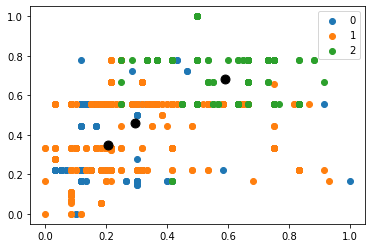

In [55]:
#Getting the Centroids
label = kmeanModel.fit_predict(data_minmax)
centroids = kmeanModel.cluster_centers_
u_labels = np.unique(label)
X= data_minmax.values
#X= rfm[['Recency','Frequency','Monetary']].values
#plotting the results:
 
for i in u_labels:
    plt.scatter(X[label == i , 0] , X[label == i , 1] ,label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()